# **Dynamic Pricing for Urban Parking Lots**

---

This project aims at addressing, analyzing and predicting the parking prices as well to  dynamically adjust the prices according to the real-time and historical demand. This is based on building an model with our ML knowledge and apply it in a very rewarding field.

# **Installation and Importing**

---
We have the installed the required Pathway and Bokesh for visualizing the changes and estimating fir the future. We have also imported the required modules used in our project.


In [ ]:
!pip install pathway bokeh --quiet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import pathway as pw
import bokeh.plotting
import panel as pn

# **Loading the data**

---

We load the dataset consisting of 18367 rows of records with columns providing the information on ID, SystemCodeNumber, Capacity,	Latitude,	Longitude,	Occupancy,	VehicleType,	TrafficConditionNearby,	QueueLength,	IsSpecialDay,	LastUpdatedDate and	LastUpdatedTime.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset (3).csv


In [ ]:
df = pd.read_csv("dataset.csv")
df.head()

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [ ]:
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],format='%d-%m-%Y %H:%M:%S')
df = df.sort_values('Timestamp').reset_index(drop=True)

In [ ]:
df.head()

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime,Timestamp
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00,2016-10-04 07:59:00
1,5248,BHMNCPHST01,1200,26.140014,91.731000,237,bike,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00
2,3936,BHMMBMMBX01,687,20.000035,78.000003,264,car,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00
3,6560,BHMNCPNST01,485,26.140048,91.730972,249,car,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00
4,17056,Shopping,1920,26.150504,91.733531,614,cycle,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00


# **Schema Declaration**

---
We declare a schema to describe the structure of the incoming data.


In [ ]:
df[["Timestamp", "Occupancy", "Capacity"]].to_csv("parking_stream.csv", index=False)

In [ ]:
class ParkingSchema(pw.Schema):
  Timestamp:str
  Occupancy:int
  Capacity:int
data=pw.demo.replay_csv("parking_stream.csv",schema=ParkingSchema,input_rate=1000)

# **Model 1: Baseline Linear Model**

---

We have modelled this part by using the Ocuupancy and Capacity. We have set the datetime in t and have evaluated and trained the model with **Price = base + alpha × (Occupancy / Capacity)**. We have captured the changed in a day using the .pathway and have used delta_window to grab are the data assiciated with it. We then  used the Bokeh plot to observe the trend in order to conclude our results.

In [ ]:
fmt="%Y-%m-%d %H:%M:%S"
data_with_time=data.with_columns(t=data.Timestamp.dt.strptime(fmt),day=data.Timestamp.dt.strptime(fmt).dt.strftime("%Y-%m-%dT00:00:00"))

In [ ]:
base=10
alp=5
@pw.udf
def model1(occ,cap):
  if cap==0:
    return base
  else:
    return ((occ/cap)*alp+base)

In [ ]:
df["Price"]=base+alp*df["Occupancy"]/df["Capacity"]

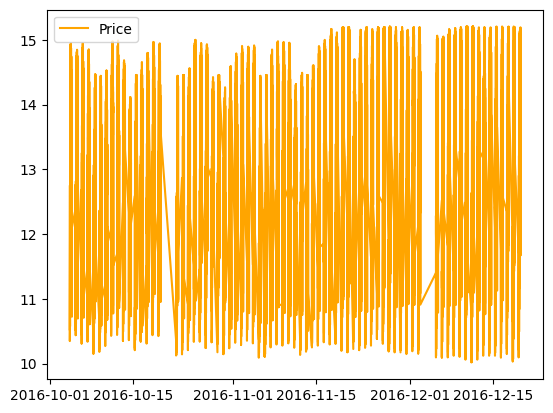

In [ ]:
plt.plot(df["Timestamp"], df["Price"], label="Price", color="orange")
plt.legend()

In [ ]:
from datetime import timedelta

In [ ]:
delta_window = (data_with_time.windowby(pw.this.t,instance=pw.this.day,window=pw.temporal.tumbling(timedelta(days=1)),behavior=pw.temporal.exactly_once_behavior()).reduce(t=pw.this._pw_window_end,occ_max=pw.reducers.max(pw.this.Occupancy),occ_min=pw.reducers.min(pw.this.Occupancy),cap=pw.reducers.max(pw.this.Capacity),).with_columns(Price=base + (pw.this.occ_max - pw.this.occ_min) / pw.this.cap))

In [ ]:
view = delta_window.select(delta_window.t, delta_window.Price)

In [ ]:
delta_window.show()

Column
    [0] Row
        [0] Markdown(str)
        [1] TooltipIcon(value='Table depends o...)
    [1] Tabulator(disabled=True, height=400, page_size=10, pagination='local', show_index=False, sizing_mode='stretch_width', value=Empty DataFrame
Columns: [...)

In [ ]:
pn.extension()
def price_plotter(source):
  fig=bokeh.plotting.figure(height=400,width=800,title="Model 1: Baseline Linear Model",x_axis_type="datetime")
  fig.line(source=source,x="t",y="Price",color="orange")
  fig.circle(source=source,x="t",y="Price",color="orange",size=4)
  return fig
viz=view.plot(price_plotter,sorting_col="t")
pn.Column(viz).servable()

Column
    [0] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)

In [ ]:
pw.run()

Output()

# **Model 2: Demand-Based Price Function**

---

We have modelled this part by using the Ocuupancy and Capacity along with some factors that affect the demand. We have set the datetime in t and have evaluated and trained the model with **Price = BasePrice × (1 + λ × NormalizedDemand)**. We created the demand function based on various factors:The demand function considered factors like queue length, traffic level, special day and vehicle type with different weightages. We have captured the changed in a day using the .pathway and have used delta_window to grab are the data assiciated with it. We then  used the Bokeh plot to observe the trend in order to conclude our results.

In [ ]:
@pw.udf
def simulate_queue(t):
    return random.randint(0,10)

@pw.udf
def simulate_traffic(t):
    return random.uniform(0.0,1.0)

@pw.udf
def simulate_special_day(t):
    dt = datetime.datetime.strptime(t,"%Y-%m-%d %H:%M:%S")
    return 1 if dt.weekday() >= 5 else 0

@pw.udf
def simulate_vehicle_type_weight(t):
    return random.choice([1.0,1.2,1.5])

In [ ]:
data_ext = data_with_time.with_columns(QueueLength=simulate_queue(data_with_time.Timestamp),TrafficLevel=simulate_traffic(data_with_time.Timestamp),IsSpecialDay=simulate_special_day(data_with_time.Timestamp),VehicleTypeWeight=simulate_vehicle_type_weight(data_with_time.Timestamp))

In [ ]:
alpha=2.0
beta=1.5
gamma=1.0
delta=1.0
epsilon=0.5
lambda_=0.4
base_price=10

In [ ]:
@pw.udf
def model2(occ, cap, q_len, traffic, special, vtype):
    if cap == 0:
        return base_price
    demand=(alpha*(occ / cap)+beta*q_len-gamma*traffic+delta*special+epsilon*vtype)
    norm_demand=max(0,min(1,(demand+2)/4))
    price=base_price*(1+lambda_ *norm_demand)
    price=min(max(price,0.5*base_price),2*base_price)
    return price

In [ ]:
result2=data_ext.select(Timestamp=data_ext.Timestamp,Occupancy=data_ext.Occupancy,Capacity=data_ext.Capacity,t=data_ext.t,day=data_ext.day,Price=model2(data_ext.Occupancy,data_ext.Capacity,data_ext.QueueLength,data_ext.TrafficLevel,data_ext.IsSpecialDay,data_ext.VehicleTypeWeight))

In [ ]:
delta_window2=(result2.windowby(pw.this.t,instance=pw.this.day,window=pw.temporal.tumbling(datetime.timedelta(days=1)),behavior=pw.temporal.exactly_once_behavior()).reduce(t=pw.this._pw_window_end,price_max=pw.reducers.max(pw.this.Price),price_min=pw.reducers.min(pw.this.Price)).with_columns(Price=pw.this.price_max ))


In [ ]:
view2=delta_window2.select(delta_window2.t,delta_window2.Price)

In [ ]:
delta_window2.show()

Traceback (most recent call last):
 File "/usr/local/lib/python3.11/dist-packages/pyviz_comms/__init__.py", line 341, in _handle_msg
 self._on_msg(msg)
 File "/usr/local/lib/python3.11/dist-packages/panel/viewable.py", line 500, in _on_msg
 doc.unhold()
 File "/usr/local/lib/python3.11/dist-packages/bokeh/document/document.py", line 776, in unhold
 self.callbacks.unhold()
 File "/usr/local/lib/python3.11/dist-packages/bokeh/document/callbacks.py", line 441, in unhold
 self.trigger_on_change(event)
 File "/usr/local/lib/python3.11/dist-packages/bokeh/document/callbacks.py", line 418, in trigger_on_change
 invoke_with_curdoc(doc, event.callback_invoker)
 File "/usr/local/lib/python3.11/dist-packages/bokeh/document/callbacks.py", line 453, in invoke_with_curdoc
 return f()
 ^^^
 File "/usr/local/lib/python3.11/dist-packages/bokeh/util/callback_manager.py", line 174, in invoke
 callback(attr, old, new)
 File "/usr/local/lib/python3.11/dist-packages/panel/reactive.py", line 559, in _comm_change
 state._handle_exception(e)
 File "/usr/local/lib/python3.11/dist-packages/panel/io/state.py", line 488, in _handle_exception
 raise exception
 File "/usr/local/lib/python3.11/dist-packages/panel/reactive.py", line 557, in _comm_change
 self._schedule_change(doc, comm)
 File "/usr/local/lib/python3.11/dist-packages/panel/reactive.py", line 539, in _schedule_change
 self._change_event(doc)
 File "/usr/local/lib/python3.11/dist-packages/panel/reactive.py", line 535, in _change_event
 self._process_events(events)
 File "/usr/local/lib/python3.11/dist-packages/panel/widgets/tables.py", line 1381, in _process_events
 return super()._process_events(events)
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 File "/usr/local/lib/python3.11/dist-packages/panel/reactive.py", line 1451, in _process_events
 self._process_data(events.pop('data'))
 File "/usr/local/lib/python3.11/dist-packages/panel/widgets/tables.py", line 1471, in _process_data
 return super()._process_data(data)
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^
 File "/usr/local/lib/python3.11/dist-packages/panel/reactive.py", line 1424, in _process_data
 self._update_column(col, converted)
 File "/usr/local/lib/python3.11/dist-packages/panel/widgets/tables.py", line 1786, in _update_column
 self.value.loc[index, column] = array
 ~~~~~~~~~~~~~~^^^^^^^^^^^^^^^
 File "/usr/local/lib/python3.11/dist-packages/pandas/core/indexing.py", line 911, in __setitem__
 iloc._setitem_with_indexer(indexer, value, self.name)
 File "/usr/local/lib/python3.11/dist-packages/pandas/core/indexing.py", line 1942, in _setitem_with_indexer
 self._setitem_with_indexer_split_path(indexer, value, name)
 File "/usr/local/lib/python3.11/dist-packages/pandas/core/indexing.py", line 1998, in _setitem_with_indexer_split_path
 raise ValueError(
ValueError: Must have equal len keys and value when setting with an iterable
 


 Traceback (most recent call last):
 File "/usr/local/lib/python3.11/dist-packages/pyviz_comms/__init__.py", line 341, in _handle_msg
 self._on_msg(msg)
 File "/usr/local/lib/python3.11/dist-packages/panel/viewable.py", line 500, in _on_msg
 doc.unhold()
 File "/usr/local/lib/python3.11/dist-packages/bokeh/document/document.py", line 776, in unhold
 self.callbacks.unhold()
 File "/usr/local/lib/python3.11/dist-packages/bokeh/document/callbacks.py", line 441, in unhold
 self.trigger_on_change(event)
 File "/usr/local/lib/python3.11/dist-packages/bokeh/document/callbacks.py", line 418, in trigger_on_change
 invoke_with_curdoc(doc, event.callback_invoker)
 File "/usr/local/lib/python3.11/dist-packages/bokeh/document/callbacks.py", line 453, in invoke_with_curdoc
 return f()
 ^^^
 File "/usr/local/lib/python3.11/dist-packages/bokeh/util/callback_manager.py", line 174, in invoke
 callback(attr, old, new)
 File "/usr/local/lib/python3.11/dist-packages/panel/reactive.py", line 559, in _comm_change
 state._handle_exception(e)
 File "/usr/local/lib/python3.11/dist-packages/panel/io/state.py", line 488, in _handle_exception
 raise exception
 Fil

Column
    [0] Row
        [0] Markdown(str)
        [1] TooltipIcon(value='Table depends o...)
    [1] Tabulator(disabled=True, height=400, page_size=10, pagination='local', show_index=False, sizing_mode='stretch_width', value=Empty DataFrame
Columns: [...)

In [ ]:
def price_plotter2(source):
    fig = bokeh.plotting.figure(
        height=400,
        width=800,
        title="Model 2: Demand-Based Price Function",
        x_axis_type="datetime"
    )
    fig.line(source=source, x="t", y="Price", color="orange")
    fig.circle(source=source, x="t", y="Price", color="orange", size=4)
    return fig

viz2 = view2.plot(price_plotter2, sorting_col="t")
pn.Column(viz2).servable()

Column
    [0] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)

In [ ]:
import random

In [ ]:
pw.run()

Output()

# **Final Thoughts**

---

This project was a highly engaging and valuable experience that challenged us to apply our machine learning knowledge with the collaboration with .pathway and Bokeh plotting.  A lot more can be done in the future by more efficient model and usage of further more resourses for a good and useful prediction.